## Overview

Using [Gemma2_9b](https://huggingface.co/unsloth/gemma-2-9b-it-bnb-4bit) from unsloth team as base + LoRA adapter on top of it

using finetuned Gemma2 for multilingual tasks : https://huggingface.co/BAAI/bge-multilingual-gemma2  
-> A LLM-based multilingual embedding model, trained on a diverse range of languages and tasks. 

LoRA approximates model's weigths by factorising Q, K, V matrices into much smaller ones.  

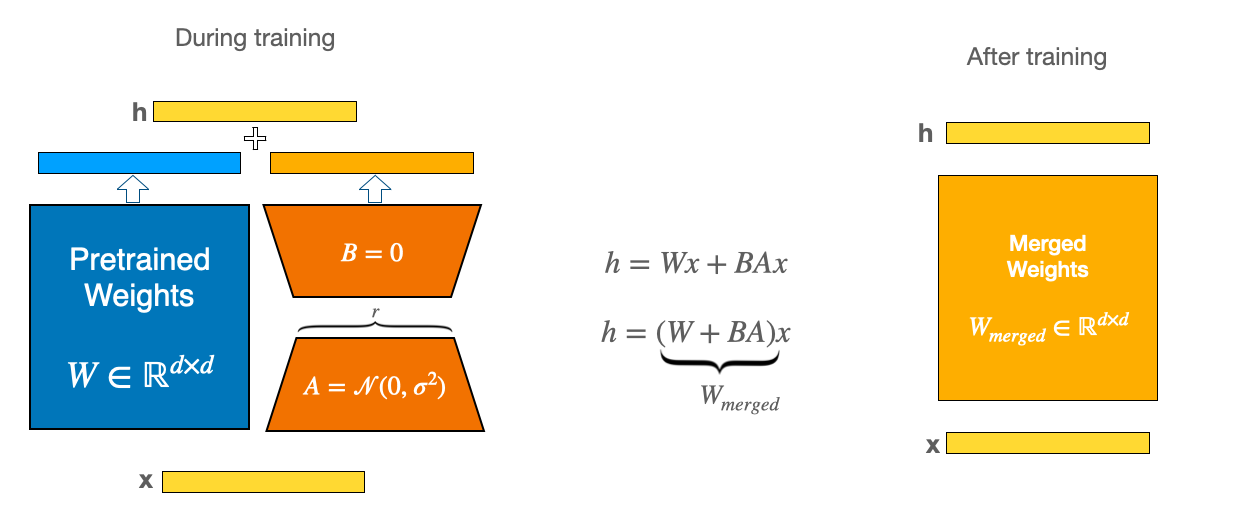  

Only those matrices will be updated during trainning -> reduce GPU memory usage. This is done with very little loss (casualities) on final metric.

> Note that QLoRA only quantize LLM's weights in low precision (e.g. 8-bit) while the computation of forward/backward are done in higher precision (e.g. 16-bit) and LoRA adapter's weights are also kept in higher precision.

HugginFace's Quantization Page : https://huggingface.co/docs/peft/developer_guides/quantization

Inspiration notebook https://www.kaggle.com/code/emiz6413/inference-gemma-2-9b-4-bit-qlora

Note : This will probably take a long time, i need to take some of mine to check for external compute resource for full trainning:
- RunPod : https://docs.runpod.io/tutorials/pods/run-fooocus
- Paperspace : https://www.paperspace.com/notebooks

## Imports

In [1]:
# gemma-2 is available from transformers>=4.42.3

import transformers as trsf
print("Transformers:", trsf.__version__)

#!pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft

Transformers: 4.47.1


In [2]:
import os
import copy
from dataclasses import dataclass
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

#from datasets import Dataset

from tqdm import tqdm

from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    Gemma2Model,
    GemmaTokenizerFast,
    Gemma2Config,
    AutoTokenizer,
    AutoModel,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    get_cosine_schedule_with_warmup,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import ModelsUtils as Utils
import Configurations as Configs
#import wsdm_modelutils as Utils

In [3]:
import peft as pft
print("Peft:", pft.__version__)

Peft: 0.14.0


In [4]:
print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


## Config

In [5]:
config_file = 'Configs.py'
manager = Configs.ConfigManager(config_file)

config = manager.micro

#config = manager.runpod_1
#load_from_config = manager.save_load_gemma2_2b_fp16
#load_from_config = manager.save_load_gemma2_2b_fp16_hidden_512
config.config_name

'micro_gemma2_2b_fp16_4bit'

### Paths

In [6]:
base_model_path = config.basemodel_path

peft_model_path = '../Checkpoints/'
checkpoint_name = "Original_notrain"
dataframe_path = config.train_data


## LoRA Config

In [7]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj"],
    #layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.FEATURE_EXTRACTION, #SEQ_CLS
)

## Data

In [8]:
df = pd.read_csv(dataframe_path)
df.head(1)

C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_11996\552262335.py:1: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataframe_path)


,id,prompt,response_a,response_b,winner,language,class_label,prompt_len,response_a_len,response_b_len,...,prompt_chinese,prompt_round_balance,prompt_curly_balance,prompt_json,prompt_sentiment,response_a_sentiment,response_b_sentiment,cosine_similarity_a,cosine_similarity_b,cosine_similarity_diff
0,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,model_b,NaN,1,192,3096,3592,...,0.0,0,0,0,0.077778,0.058469,0.139458,0.705321,0.629803,0.075518


In [9]:
df['prompt'] = df['prompt'].astype(str)
df['response_a'] = df['response_a'].astype(str)
df['response_b'] = df['response_b'].astype(str)

## Tokenize

In [10]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.add_eos_token = True      # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [11]:
df = df.sample(frac=config.sample_size, random_state=config.random_seed)

In [12]:
def tokenize_df(row):
    return Utils.tokenize(tokenizer, [row['prompt']], [row['response_a']], [row['response_b']], max_length=config.max_length)

df['tokens'] = df.apply(tokenize_df, axis=1)

In [13]:
df['len'] = df['prompt_len'] + df['response_a_len'] + df['response_b_len']

In [14]:
df.shape

(175, 72)

## Split

In [15]:
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=config.random_seed)

## Data Loader

In [16]:
# Prepare dataset and dataloader
dataset_train = Utils.ChatbotArenaDataset(df_train, tokenizer, max_length=config.max_length)
dataloader_train = Utils.DataLoader(dataset_train, batch_size=config.train_batch, shuffle=True)

dataset_valid = Utils.ChatbotArenaDataset(df_valid, tokenizer, max_length=config.max_length)
dataloader_valid = Utils.DataLoader(dataset_valid, batch_size=config.eval_batch, shuffle=True)

## Model

In [17]:
predictionModel = Utils.custom_load_model_chkpt(
                        config,
                        checkpointName="Original_notrain",
                        device=device
                        )

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [18]:
predictionModel

PreferencePredictionModel(
  (gemma_model): PeftModel(
    (base_model): LoraModel(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
     

In [19]:
optimizer = optim.AdamW([
    {'params': predictionModel.gemma_model.parameters(), 'lr': config.base_model_lr},     # Lower learning rate for transformer layers
    {'params': predictionModel.feature_fc.parameters(), 'lr': config.feature_fc_lr},      # Higher learning rate for custom layers
    {'params': predictionModel.classifier.parameters(), 'lr': config.classifier_lr},      # Higher learning rate for custom layers
], weight_decay=0.01)

#optimizer = optim.AdamW(predictionModel.parameters(), weight_decay=0.01)
#optimizer = optim.Adam(predictionModel.parameters())

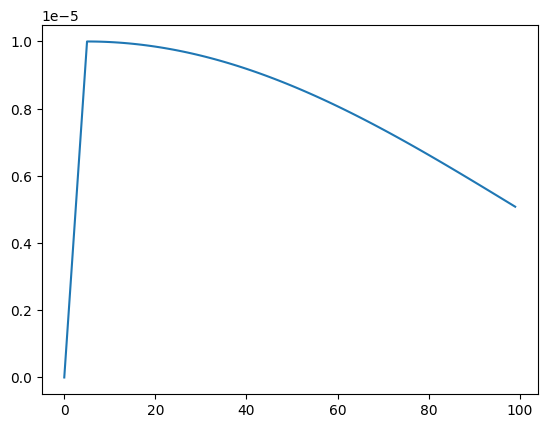

In [20]:
import matplotlib.pyplot as plt

num_training_steps = 100
num_warmup_steps = int(0.05 * num_training_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    num_cycles=0.25
)

lrs = []

for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    lr_scheduler.step()

plt.plot(range(100),lrs)

In [21]:
num_training_steps = len(dataloader_train) * config.n_epochs
num_warmup_steps = int(0.05 * num_training_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    num_cycles=0.25
)

## Train

In [22]:
predictionModel.gemma_model.config.hidden_size

2304

In [23]:
history = Utils.train_model(predictionModel, dataloader_train, dataloader_valid, optimizer, config, scheduler=lr_scheduler, device=device)

  0%|          | 0/9 [00:00<?, ?row/s]The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
100%|██████████| 9/9 [00:01<00:00,  6.23row/s]


Epoch 1 Finished
Accumulated Train Loss: 0.6921110786969149
Accumulated Train Accuracy: 0.535031847133758
Valid Loss: 0.7156285908487108, Valid Accuracy : 0.3333333333333333
0.7156285908487108 val loss is better than previous inf, saving checkpoint_lossBest, epoch:  1
0.3333333333333333 val accuracy is better than previous 0, saving checkpoint_accBest, epoch:  1
-----------------------------------------------------------------


 56%|█████▌    | 5/9 [00:00<00:00,  5.19row/s]


KeyboardInterrupt: 

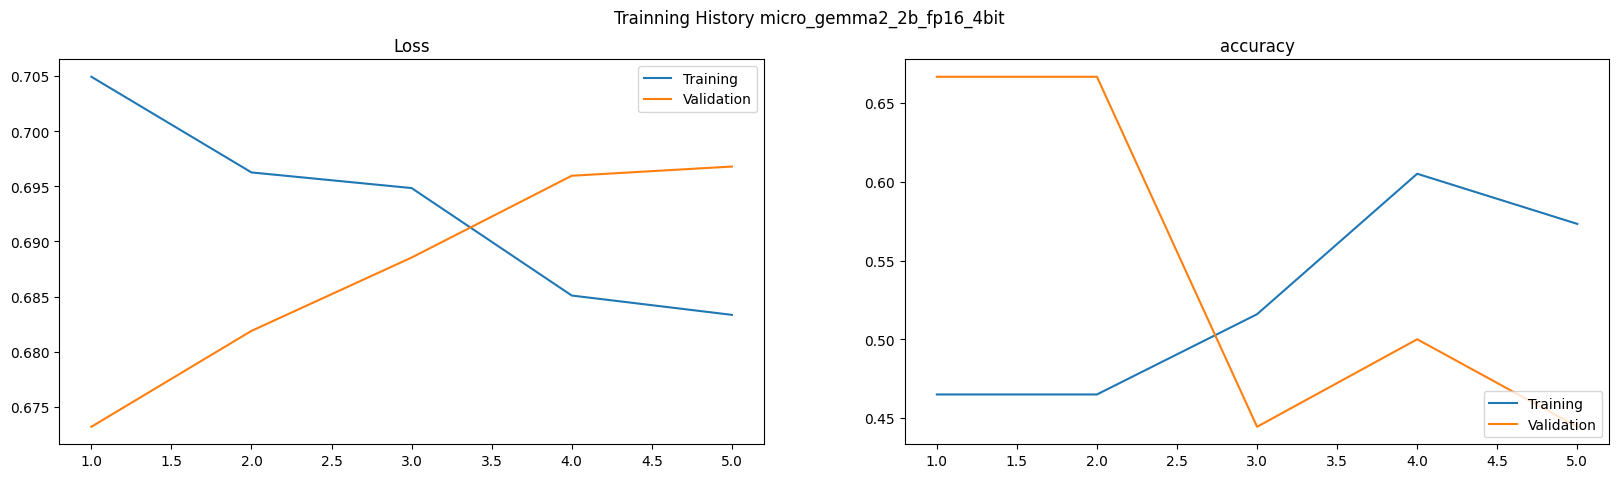

In [ ]:
Utils.plot_model_history(history, "Trainning History")

In [23]:
#!runpodctl remove pod $RUNPOD_POD_ID